# Goals

1. Define Dataset with SRM-IL (style randomizations - image level)
2. Define SRM-FL as a Separate Model (feature randomizations - feature level)
3. Integrate SRM-FL into AlexNet

Reference: https://github.com/rafizunaed/DomainAgnosticCXR/tree/main/

## Imports

In [ ]:
!pip install opendatasets

In [ ]:
import os
from torch.utils.data import Dataset, random_split, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import opendatasets as od
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import alexnet
import matplotlib.pyplot as plt
import numpy as np
from timm.utils.model_ema import ModelEmaV2

## Download Dataset and create Dataloader

In [ ]:
od.download("https://www.kaggle.com/datasets/emilyguan2/covid-dataset")
od.download("https://www.kaggle.com/datasets/andreacheng41/bangladesh-chestxray-dlproject")
od.download("https://www.kaggle.com/datasets/emilyguan2/nigeria-only")
od.download("https://www.kaggle.com/datasets/mahdiopra/rsua-chest-x-ray-dataset")

Dataset URL: https://www.kaggle.com/datasets/emilyguan2/covid-dataset


100%|██████████| 185M/185M [00:01<00:00, 179MB/s]



Dataset URL: https://www.kaggle.com/datasets/andreacheng41/bangladesh-chestxray-dlproject


100%|██████████| 42.7M/42.7M [00:00<00:00, 151MB/s]



Dataset URL: https://www.kaggle.com/datasets/emilyguan2/nigeria-only


100%|██████████| 187M/187M [00:01<00:00, 166MB/s]



Dataset URL: https://www.kaggle.com/datasets/mahdiopra/rsua-chest-x-ray-dataset


100%|██████████| 109M/109M [00:00<00:00, 165MB/s]


### SRM IL Class

Applies a normalization formula to an image's pixel values.
The paper provides the min_value and max_value using defined global config variables, but for simplicity we just default them to 0 and 255 (which is what the config variables are set to)

In [ ]:
class SRM_IL(object):
    def __init__(self, min_value=0, max_value=255):
        self.max_value = max_value
        self.min_value = min_value

    def apply_perturbation(self, image):
        image = image.astype(np.float32)
        m2 = np.random.uniform(low=self.min_value, high=self.max_value, size=(1,1,1)).repeat(3, axis=2)
        s2 = np.random.uniform(low=self.min_value, high=self.max_value, size=(1,1,1)).repeat(3, axis=2)
        m1 = np.mean(image, axis=(0,1), keepdims=True)
        v1 = np.var(image, axis=(0,1), keepdims=True)
        s1 = np.sqrt(v1)
        image = (image - m1) / s1
        image = image * s2 + m2
        return image

### CXRDataset Class

Defines a Dataset object for the Covid19 Radiography Database
Uses the SRM-IL class to randomly

In [ ]:
class CXRDataset(Dataset):
    def __init__(self, path, folder_mapping, sub_folder=None, transform=None, use_SRM_IL=True, srm_il_min=0, srm_il_max=255, print_img=False):
        """
        Args:
            folder_mapping (dict): A dictionary where keys are target labels and values are lists of folder paths.
                                   Example: {"Normal": ["path_to_Normal_folder"],
                                             "Non-Pneumonia Disease": ["path_to_COVID", "path_to_Lung_Opacity"],
                                             "Pneumonia": ["path_to_Viral_Pneumonia"]}
            transform (callable, optional): Optional transforms to be applied on an image.
            use_SRM_IL (boolean): Indicates use of SRM IL perturbations on an image.
        """
        self.print_img = print_img
        self.data = []
        self.labels = []
        self.transform = transform
        self.use_SRM_IL = use_SRM_IL

        # Load all images and assign corresponding labels
        for label, folders in folder_mapping.items():
            for folder in folders:
                folder_path = os.path.join(path, folder)
                if sub_folder:
                    folder_path = os.path.join(folder_path, sub_folder)

                for file_name in os.listdir(folder_path):
                    if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp')):  # Filter image files
                        img_path = os.path.join(folder_path, file_name)
                        self.data.append(img_path)
                        self.labels.append(label)

        # Define SRM_IL class
        if self.use_SRM_IL:
            self.SRM_IL = SRM_IL(srm_il_min, srm_il_max)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")

        if self.print_img:
            plt.imshow(image)
            plt.show()

        # Apply perturbation
        if self.use_SRM_IL:
          image = np.array(image)
          image = self.SRM_IL.apply_perturbation(image.copy())
          image = Image.fromarray(image.astype('uint8'))
          if self.print_img:
            plt.imshow(image)
            plt.show()

        # Apply transformations
        if self.transform:
          image = self.transform(image)

        return image, torch.tensor(label)


In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

srm_il_min = 0
srm_il_max = 255

# training dataset

train_data_dir_A = "covid-dataset"
train_folder_map_A = {
    0: ["A_normal_sample"],
    1: ["A_other_sample"],
    2: ["A_pn_sample"],
}

train_dataset_A = CXRDataset(train_data_dir_A, train_folder_map_A, transform=transform, use_SRM_IL=True, srm_il_min=srm_il_min, srm_il_max=srm_il_max)

train_data_dir_B = "nigeria-only"
train_folder_map_B = {
    0: ["nigeria_normal/nigeria_normal"],
    1: ["nigeria_other/nigeria_other"],
    2: ["nigeria_pneumonia/nigeria_pneumonia"]
}

train_dataset_B = CXRDataset(train_data_dir_B, train_folder_map_B, transform=transform, use_SRM_IL=True, srm_il_min=srm_il_min, srm_il_max=srm_il_max)

train_dataset = ConcatDataset([train_dataset_A, train_dataset_B])

# validation dataset

val_data_dir = "bangladesh-chestxray-dlproject"
val_folder_map = {
    0: ["Normal"],
    1: ["COVID", "Lung_Opacity"],
    2: ["Viral Pneumonia"]

}

val_dataset = CXRDataset(val_data_dir, val_folder_map, transform=transform, use_SRM_IL=False)

# test dataset
test_data_dir = "rsua-chest-x-ray-dataset/RSUA Chest X-Ray Dataset/Data Chest X-Ray RSUA (Annotated)-20230618T030427Z-001/Data Chest X-Ray RSUA (Annotated)"
test_folder_map = {
    0: ["Non_Covid"],
    1: ["Covid"],
    2: ["Non_Covid_Pneumonia"],
}

test_dataset = CXRDataset(test_data_dir, test_folder_map, sub_folder="images", transform=transform, use_SRM_IL=False)

In [ ]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

7151
4350
371


## Define AlexNet Architecture with Feature Level Perturbation Blocks

The paper/github integrates a separate SRM_FL block into the Densenet architecture; here, we integrate the SRM_FL block into the Alexnet architecture

### SRM FL Class

In [ ]:
class SRM_FL(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.eps = 1e-7
        self.gamma_net = nn.Sequential(
                            nn.Conv2d(in_channels, in_channels, 1, 1),
                            nn.Conv2d(in_channels, in_channels//2, 3, 1, 1),
                            nn.Conv2d(in_channels//2, in_channels, 3, 1, 1),
                            nn.Conv2d(in_channels, in_channels, 1, 1),
                            )
        self.beta_net = nn.Sequential(
                            nn.Conv2d(in_channels, in_channels, 1, 1),
                            nn.Conv2d(in_channels, in_channels//2, 3, 1, 1),
                            nn.Conv2d(in_channels//2, in_channels, 3, 1, 1),
                            nn.Conv2d(in_channels, in_channels, 1, 1),
                            )

    def forward(self, content_feats_orig:torch.Tensor, style_feats:torch.Tensor):
        gamma = self.gamma_net(style_feats)
        beta = self.beta_net(style_feats)
        mean_content = torch.mean(content_feats_orig, dim=[2,3], keepdim=True)
        var_content = torch.var(content_feats_orig, dim=[2,3], keepdim=True)
        content_feats = (content_feats_orig - mean_content) / (var_content + self.eps).sqrt()
        content_feats = content_feats * gamma + beta
        return content_feats

### Loss function for SRM_FL

In [ ]:
import torch.nn.functional as F

def generate_gram_matrix(x:torch.Tensor):
    (b, ch, h, w) = x.size()
    features = x.view(b, ch, w * h)
    features = F.normalize(features, dim=2, eps=1e-7)
    features_t = features.transpose(1, 2)
    gram_matrix = features.bmm(features_t)
    return gram_matrix

def calculate_content_style_loss(transformed:torch.Tensor, content_ref:torch.Tensor, style_ref:torch.Tensor):
    content_loss = F.mse_loss(transformed, content_ref)
    gm_transformed = generate_gram_matrix(transformed)
    gm_style_ref = generate_gram_matrix(style_ref)
    style_loss = F.mse_loss(gm_transformed, gm_style_ref)
    return content_loss, style_loss

### AlexNet with SRM FL Blocks

Removing randomization_stage parameter and simply integrating the SRMFL block where convenient for now

In [ ]:
from torch.cuda.amp import autocast

class AlexNet_SRMFL(nn.Module):
    def __init__(self, num_classes: int, init_srm_fl=False, randomization_stage=None):
          super().__init__()
          self._init_backbone()
          self._init_head(num_classes)
          self.init_srm_fl = init_srm_fl
          self.randomization_stage = randomization_stage

          # Validate init_srm_fl is True <=> randomization_stage is not None
          if init_srm_fl == True:
            assert randomization_stage in ['S1', 'S2', 'S3']
          if randomization_stage != None:
            assert init_srm_fl == True

          # SRM_FL expected input based on location in AlexNet
          if randomization_stage == 'S1':
              self.srm_fl = SRM_FL(192)
          elif randomization_stage == 'S2':
              self.srm_fl = SRM_FL(384)
          elif randomization_stage == 'S3':
              self.srm_fl = SRM_FL(256)


    def _init_backbone(self):
        # Load AlexNet pretrained model
        model = alexnet(pretrained=True)
        features = list(model.features)
        # Split AlexNet layers into blocks for S1, S2, S3 stages
        self.stem = nn.Sequential(*features[:3])  # Layers 0-2
        self.conv_block1 = nn.Sequential(*features[3:6])  # Layers 3-5
        self.conv_block2 = nn.Sequential(*features[6:8])  # Layers 6-7
        self.conv_block3 = nn.Sequential(*features[8:])   # Layers 8-12

        # Global average pooling
        self.avg = nn.AdaptiveAvgPool2d((6, 6))

    def _init_head(self, num_classes: int):
        # Final classifier
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def grad_turn_on_srm_fl_only(self):
        for x in [self.stem, self.conv_block1, self.conv_block2, self.conv_block3, self.classifier]:
            for _, p in enumerate(x.parameters()):
                p.requires_grad_(False)

        for _, p in enumerate(self.srm_fl.parameters()):
            p.requires_grad_(True)

    def grad_turn_off_srm_fl_only(self):
        for x in [self.stem, self.conv_block1, self.conv_block2, self.conv_block3, self.classifier]:
            for _, p in enumerate(x.parameters()):
                p.requires_grad_(True)

        for _, p in enumerate(self.srm_fl.parameters()):
            p.requires_grad_(False)

    def _forward_block(self, block, x: torch.Tensor):
        x = block(x)
        return x

    def _perturb_features(self, x: torch.Tensor, train_srm_fl: bool):
        N = x.shape[0]
        idx_swap = torch.arange(N).flip(0)
        cont_x = x.clone()
        style_x = x.clone()[idx_swap].detach()
        x_srm = self.srm_fl(cont_x, style_x)
        if train_srm_fl:
            content_loss, style_loss = calculate_content_style_loss(x_srm, cont_x, style_x)
            return {
                'content_loss': content_loss,
                'style_loss': style_loss,
                }
        else:
            return x_srm

    @autocast()
    def forward(self, x: torch.Tensor, use_srm_fl: bool = False, train_srm_fl: bool = False):
        if not self.init_srm_fl or not use_srm_fl:
            x = self.stem(x)
            x = self._forward_block(self.conv_block1, x)
            x = self._forward_block(self.conv_block2, x)
            x = self._forward_block(self.conv_block3, x)
            x = torch.flatten(x, 1)
            logits = self.classifier(x)
        else:
            x = self.stem(x)

            x = self._forward_block(self.conv_block1, x)
            if self.randomization_stage == 'S1' and use_srm_fl:
                x = self._perturb_features(x, train_srm_fl)
                if train_srm_fl:
                    return x

            x = self._forward_block(self.conv_block2, x)
            if self.randomization_stage == 'S2' and use_srm_fl:
                x = self._perturb_features(x, train_srm_fl)
                if train_srm_fl:
                    return x

            x = self._forward_block(self.conv_block3, x)
            if self.randomization_stage == 'S3' and use_srm_fl:
                x = self._perturb_features(x, train_srm_fl)
                if train_srm_fl:
                    return x

            x = self.avg(x)
            x = torch.flatten(x, 1)
            logits = self.classifier(x)

        return {
            'logits': logits,
            'gfm': x,
        }

<ipython-input-14-91243dad57a1>:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast()


## Train Model

Define a class to customize training parameters for comparison

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class ModelTrainer():
    def __init__(self,
                 model: torch.nn.Module,
                 Loaders: list,
                 lr: float,
                 epochsTorun: int,
                 do_grad_accum: False,
                 grad_accum_step: int,
                 use_ema: bool,
                 eta: float,
                 use_SRM_FL: bool,
                 ):
        super().__init__()

        self.model = model.to(DEVICE)
        self.trainLoader = Loaders[0]
        self.valLoader = Loaders[1]
        self.eta = eta
        self.lr = lr
        self.epochsTorun = epochsTorun

        self.criterion_cls = nn.CrossEntropyLoss()

        self.scaler = torch.cuda.amp.GradScaler()
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.lr)

        self.do_grad_accum = do_grad_accum
        self.grad_accum_step = grad_accum_step

        self.use_ema = use_ema
        if self.use_ema:
            self.model_ema = ModelEmaV2(self.model, decay=0.997, device=DEVICE)

        self.use_SRM_FL = use_SRM_FL

    def save_checkpoint(self, epoch, train_loss, train_acc, val_loss, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scaler_state_dict': self.scaler.state_dict(),
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_acc': val_acc
        }

        if self.use_ema:
            checkpoint['model_ema_state_dict'] = self.model_ema.state_dict()

        torch.save(checkpoint, f'checkpoint_epoch_{epoch+1}.pth')
        print(f"Checkpoint saved for epoch {epoch+1}")

    def load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scaler.load_state_dict(checkpoint['scaler_state_dict'])

        if self.use_ema and 'model_ema_state_dict' in checkpoint:
            self.model_ema.load_state_dict(checkpoint['model_ema_state_dict'])

        return checkpoint['epoch']


    def perform_validation(self, use_progbar=True):
        self.model.eval()
        if self.use_ema:
            self.model_ema.eval()
        torch.set_grad_enabled(False)

        print(f'(Val) Epoch {self.current_epoch_no}/{self.epochsTorun}')

        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in self.valLoader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            with torch.no_grad() and torch.amp.autocast(device_type='cuda'):
                if self.use_ema:
                    out = self.model_ema.module(images)
                else:
                    out = self.model(images)
                batch_loss = self.criterion_cls(out['logits'], labels)
                running_loss += batch_loss.item()

            # update metrics
            _, predicted = out['logits'].max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # calculate metrics and return
        epoch_loss = running_loss / len(self.valLoader)
        epoch_accuracy = correct / total
        return epoch_loss, epoch_accuracy

    def train_one_epoch_style_net(self):

        print(f'(Train Style Net) Epoch {self.current_epoch_no}/{self.epochsTorun}')

        self.model.train()
        torch.set_grad_enabled(True)
        self.optimizer.zero_grad()

        if self.use_ema:
            self.model_ema.train()

        self.model.grad_turn_on_srm_fl_only()

        running_content_loss = 0.0
        running_style_loss = 0.0

        for itera_no, (images, labels) in enumerate(self.trainLoader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            with torch.cuda.amp.autocast():
                out = self.model(images, use_srm_fl=True, train_srm_fl=True)
                content_loss = out['content_loss'].mean()
                style_loss = self.eta * out['style_loss'].mean()
            self.scaler.scale(content_loss+style_loss).backward()

            if self.do_grad_accum:
                if (itera_no+1)%self.grad_accum_step == 0:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()

                    if self.use_ema:
                        self.model_ema.update(self.model)
            else:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

                if self.use_ema:
                    self.model_ema.update(self.model)

            # update metrics
            running_content_loss += content_loss.detach().item()
            running_style_loss += style_loss.detach().item()

            if (itera_no+1) % 100 == 0:
                print(f'    Iter {itera_no}/{len(self.trainLoader)} | Train Content Loss: {content_loss}, Train Style Loss: {style_loss}')

        # calculate metrics and return
        epoch_content_loss = running_content_loss / len(self.trainLoader)
        epoch_style_loss = running_style_loss / len(self.trainLoader)
        return epoch_content_loss, epoch_style_loss

    def train_one_epoch(self):

        print(f'(Train Classifier) Epoch {self.current_epoch_no}/{self.epochsTorun}')

        self.model.train()
        torch.set_grad_enabled(True)
        self.optimizer.zero_grad()

        if self.use_ema:
            self.model_ema.train()

        self.model.grad_turn_off_srm_fl_only()

        running_loss = 0.0
        correct = 0
        total = 0

        for itera_no, (images, labels) in enumerate(self.trainLoader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            with torch.cuda.amp.autocast():
                out = self.model(images, use_srm_fl=True, train_srm_fl=False)
                cls_loss = self.criterion_cls(out['logits'], labels)
                batch_loss = cls_loss

            self.scaler.scale(batch_loss).backward()

            if self.do_grad_accum:
                if (itera_no+1)%self.grad_accum_step == 0:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()

                    if self.use_ema:
                        self.model_ema.update(self.model)
            else:
                self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer.zero_grad()

                if self.use_ema:
                    self.model_ema.update(self.model)

            # update metrics
            _, predicted = out['logits'].max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            running_loss += batch_loss.item()

            if itera_no % 100 == 0:
                print(f'    Iter {itera_no}/{len(self.trainLoader)} | Train Loss: {batch_loss}')

        # calculate metrics and return
        epoch_loss = running_loss / len(self.trainLoader)
        epoch_accuracy = correct / total
        return epoch_loss, epoch_accuracy

    # train part starts here
    def fit(self, resume_from_checkpoint):

        # keep track of losses and accuracies

        train_cont_losses = []
        train_style_losses = []
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        start_epoch = 0
        if resume_from_checkpoint:
            print(f"Resuming training from epoch")
            start_epoch = self.load_checkpoint(resume_from_checkpoint)
            print(f"Resuming training from epoch {start_epoch}")

        for epoch in range(start_epoch, self.epochsTorun):
            self.current_epoch_no = epoch+1
            if self.use_SRM_FL:
              train_content_loss, train_style_loss = self.train_one_epoch_style_net()
              print(f'  Train Content Loss: {train_content_loss}, Train Style Loss: {train_style_loss}')
            train_loss, train_acc = self.train_one_epoch()
            val_loss, val_acc = self.perform_validation()
            print(f'  Train Loss: {train_loss}, Train Acc: {train_acc}, Val Loss: {val_loss}, Val Acc: {val_acc}')

            train_cont_losses.append(train_content_loss)
            train_style_losses.append(train_style_loss)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            # save model at this epoch
            self.save_checkpoint(epoch, train_losses[-1], train_accuracies[-1], val_losses[-1], val_accuracies[-1])

        # save losses and accuracies
        np.savez(
          "srm_il_fl_metrics.npz",
          train_cont_losses=train_cont_losses,
          train_style_losses=train_style_losses,
          train_losses=train_losses,
          train_accs=train_accuracies,
          val_losses=val_losses,
          val_accs=val_accuracies,
        )

        return train_cont_losses, train_style_losses, train_losses, train_accuracies, val_losses, val_accuracies

### Train model on IL & FL

Parameters chosen based on paper's github default values
Image level perturbations applied only

In [ ]:
model = AlexNet_SRMFL(num_classes=3, init_srm_fl=True, randomization_stage='S1')

trainer_args = {
                'model': model,
                'Loaders': [train_loader, val_loader],
                'lr': 0.0001,
                'epochsTorun': 15,
                'do_grad_accum': True,
                'grad_accum_step': 4,
                'use_ema': True,
                'eta': 1.5,
                'use_SRM_FL': True
                }

trainer = ModelTrainer(**trainer_args)
metrics = trainer.fit(resume_from_checkpoint=None)

<ipython-input-16-e67318a23f66>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


(Train Style Net) Epoch 1/15


<ipython-input-16-e67318a23f66>:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


    Iter 99/224 | Train Content Loss: 9.131458282470703, Train Style Loss: 0.0902959555387497
    Iter 199/224 | Train Content Loss: 7.555398941040039, Train Style Loss: 0.06037618964910507
  Train Content Loss: 12.108271277376584, Train Style Loss: 0.1218096365753029
(Train Classifier) Epoch 1/15


<ipython-input-16-e67318a23f66>:172: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


    Iter 0/224 | Train Loss: 1.1181793212890625
    Iter 100/224 | Train Loss: 0.7692832946777344
    Iter 200/224 | Train Loss: 0.255512535572052
(Val) Epoch 1/15
  Train Loss: 0.7531371590282235, Train Acc: 0.6369738498112152, Val Loss: 1.0158947890295702, Val Acc: 0.5802298850574713
Checkpoint saved for epoch 1
(Train Style Net) Epoch 2/15
    Iter 99/224 | Train Content Loss: 7.82893180847168, Train Style Loss: 0.05963924154639244
    Iter 199/224 | Train Content Loss: 6.572045803070068, Train Style Loss: 0.052247945219278336
  Train Content Loss: 6.540525063872337, Train Style Loss: 0.0524289634777233
(Train Classifier) Epoch 2/15
    Iter 0/224 | Train Loss: 0.6016584634780884
    Iter 100/224 | Train Loss: 0.44881343841552734
    Iter 200/224 | Train Loss: 0.3588939607143402
(Val) Epoch 2/15
  Train Loss: 0.4388600697607866, Train Acc: 0.811215214655293, Val Loss: 0.8331594953642172, Val Acc: 0.588735632183908
Checkpoint saved for epoch 2
(Train Style Net) Epoch 3/15
    Iter 99

KeyboardInterrupt: 

In [ ]:
train_cont_losses, train_style_losses, train_losses, train_accuracies, val_losses, val_accuracies = metrics

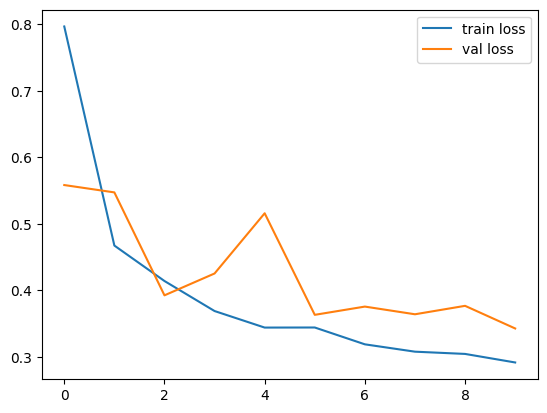

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

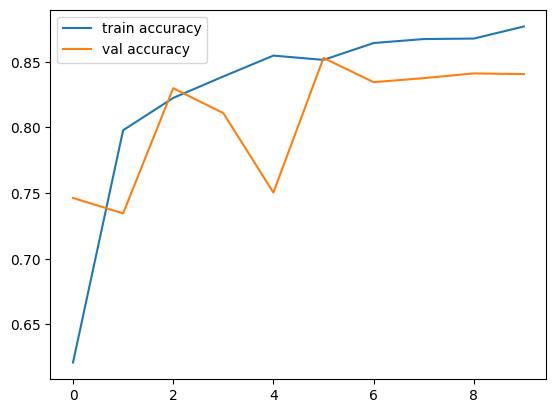

In [ ]:
plt.plot(train_accuracies, label="train accuracy")
plt.plot(val_accuracies, label="val accuracy")
plt.legend()
plt.show()

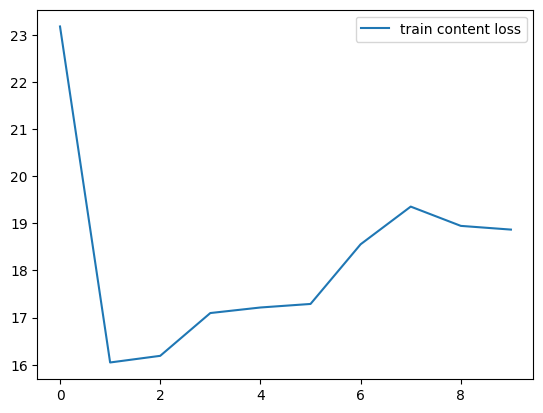

In [ ]:
plt.plot(train_cont_losses, label="train content loss")
plt.legend()
plt.show()

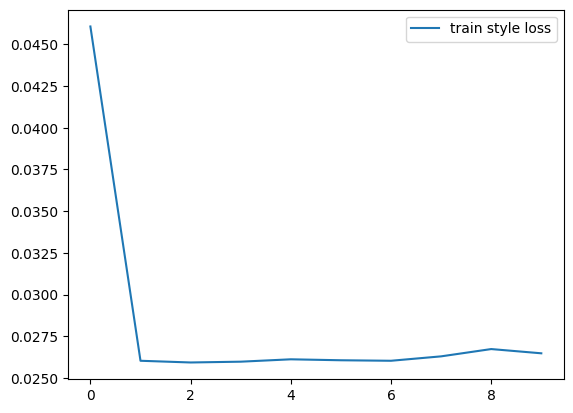

In [ ]:
plt.plot(train_style_losses, label="train style loss")
plt.legend()
plt.show()

In [ ]:
# Save model checkpoint
torch.save({
   'model_state_dict': model.state_dict(),
}, "srm_il_fl_final.pth")

## Train for longer if needed

In [ ]:
model = AlexNet_SRMFL(num_classes=3, init_srm_fl=True, randomization_stage='S1')

trainer_args2 = {
                'model': model,
                'Loaders': [train_loader, val_loader],
                'lr': 0.0001,
                'epochsTorun': 15,
                'do_grad_accum': True,
                'grad_accum_step': 4,
                'use_ema': False,
                'eta': 0.5,
                'use_SRM_FL': True
                }

current_checkpoint = "checkpoint_epoch_10.pth"

trainer2 = ModelTrainer(**trainer_args2)
metrics2 = trainer2.fit(resume_from_checkpoint=current_checkpoint)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-94-90e43f2c8bc7>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
<ipython-input-94-90e43f2c8bc7>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module im

Resuming training from epoc
Resuming training from epoch 10
(Train Style Net) Epoch 11/15


<ipython-input-94-90e43f2c8bc7>:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


    Iter 99/258 | Train Content Loss: 22.714313507080078, Train Style Loss: 0.02918398380279541
    Iter 199/258 | Train Content Loss: 18.116287231445312, Train Style Loss: 0.02785784751176834
  Train Content Loss: 19.23417198195938, Train Style Loss: 0.026426259341628053
(Train Classifier) Epoch 11/15


<ipython-input-94-90e43f2c8bc7>:172: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


    Iter 0/258 | Train Loss: 0.1022641584277153
    Iter 100/258 | Train Loss: 0.25941556692123413
    Iter 200/258 | Train Loss: 0.3314688801765442
(Val) Epoch 11/15
  Train Loss: 0.2742747907606206, Train Acc: 0.8865454545454545, Val Loss: 0.37252242496756255, Val Acc: 0.831881086622245
Checkpoint saved for epoch 15
(Train Style Net) Epoch 12/15
    Iter 99/258 | Train Content Loss: 16.283935546875, Train Style Loss: 0.02592281810939312
    Iter 199/258 | Train Content Loss: 21.118467330932617, Train Style Loss: 0.022475438192486763
  Train Content Loss: 19.17226731130319, Train Style Loss: 0.026128400442038856
(Train Classifier) Epoch 12/15
    Iter 0/258 | Train Loss: 0.1909734606742859
    Iter 100/258 | Train Loss: 0.1957225352525711
    Iter 200/258 | Train Loss: 0.1477925330400467
(Val) Epoch 12/15
  Train Loss: 0.2736048117251128, Train Acc: 0.8848484848484849, Val Loss: 0.4051332559253349, Val Acc: 0.8339313172731933
Checkpoint saved for epoch 15
(Train Style Net) Epoch 13/15

In [ ]:
train_cont_losses_2, train_style_losses_2, train_losses_2, train_accuracies_2, val_losses_2, val_accuracies_2 = metrics2

In [ ]:
val_accuracies = [item for sublist in val_accuracies for item in (sublist if isinstance(sublist, list) else [sublist])]

In [ ]:
train_cont_losses += train_cont_losses_2
train_style_losses += train_style_losses_2
train_losses += train_losses_2
train_accuracies += train_accuracies_2
val_losses += val_losses_2
val_accuracies += val_accuracies_2

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (11,) + inhomogeneous part.

In [ ]:
np.savez(
          "srm_il_fl_metrics.npz",
          train_cont_losses=train_cont_losses,
          train_style_losses=train_style_losses,
          train_losses=train_losses,
          train_accs=train_accuracies,
          val_losses=val_losses,
          val_accs=val_accuracies,
        )

In [ ]:
# Save model checkpoint
torch.save({
   'model_state_dict': model.state_dict(),
}, "srm_il_fl_final.pth")

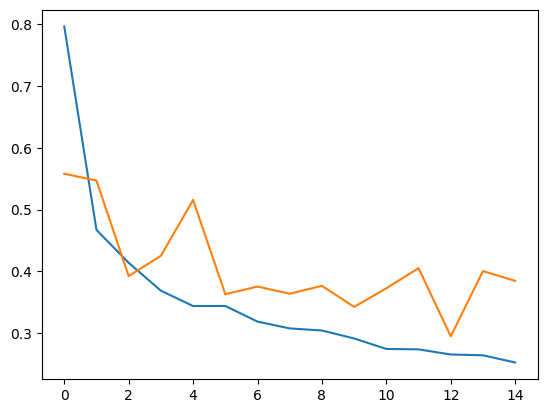

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.show()

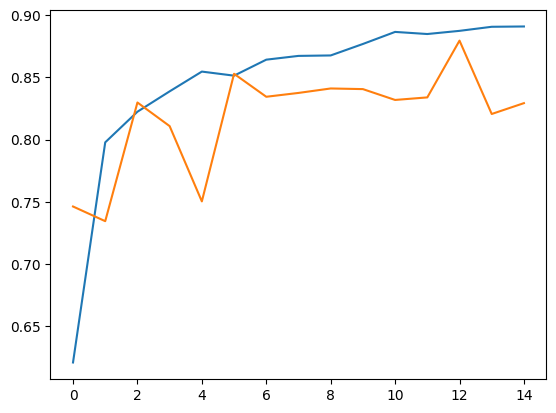

In [ ]:
plt.plot(train_accuracies)
plt.plot(val_accuracies)
plt.show()

In [ ]:
model = AlexNet_SRMFL(num_classes=3, init_srm_fl=True, randomization_stage='S1')

trainer_args3 = {
                'model': model,
                'Loaders': [train_loader, val_loader],
                'lr': 0.0001,
                'epochsTorun': 20,
                'do_grad_accum': True,
                'grad_accum_step': 4,
                'use_ema': False,
                'eta': 0.5,
                'use_SRM_FL': True
                }

current_checkpoint = "checkpoint_epoch_15.pth"

trainer3 = ModelTrainer(**trainer_args3)
metrics3 = trainer3.fit(resume_from_checkpoint=current_checkpoint)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-124-1c942fad1775>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
<ipython-input-124-1c942fad1775>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module 

Resuming training from epoch
Resuming training from epoch 15
(Train Style Net) Epoch 16/20


<ipython-input-124-1c942fad1775>:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


    Iter 99/258 | Train Content Loss: 23.40091323852539, Train Style Loss: 0.02957317978143692
    Iter 199/258 | Train Content Loss: 17.597476959228516, Train Style Loss: 0.022576717659831047
  Train Content Loss: 19.71729317746421, Train Style Loss: 0.02624338444380104
(Train Classifier) Epoch 16/20


<ipython-input-124-1c942fad1775>:172: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


    Iter 0/258 | Train Loss: 0.36234089732170105
    Iter 100/258 | Train Loss: 0.1474699229001999
    Iter 200/258 | Train Loss: 0.26640060544013977
(Val) Epoch 16/20
  Train Loss: 0.24545174637852712, Train Acc: 0.8946666666666667, Val Loss: 0.309124550858482, Val Acc: 0.8723731419784726
Checkpoint saved for epoch 15
(Train Style Net) Epoch 17/20
    Iter 99/258 | Train Content Loss: 19.016399383544922, Train Style Loss: 0.029157469049096107
    Iter 199/258 | Train Content Loss: 18.435659408569336, Train Style Loss: 0.026143202558159828
  Train Content Loss: 19.501730297887047, Train Style Loss: 0.02647232918371988
(Train Classifier) Epoch 17/20
    Iter 0/258 | Train Loss: 0.25186944007873535
    Iter 100/258 | Train Loss: 0.24214977025985718
    Iter 200/258 | Train Loss: 0.23283898830413818
(Val) Epoch 17/20
  Train Loss: 0.2503491637925076, Train Acc: 0.8944242424242425, Val Loss: 0.3519831843307761, Val Acc: 0.8513582778062532
Checkpoint saved for epoch 16
(Train Style Net) Epo

KeyboardInterrupt: 

## Test Model

Using the sampled NIH dataset for testing, load model from checkpoint of most recent run

In [ ]:
def evaluate(model, test_loader):
  model = model.to(DEVICE)
  model.eval()
  torch.set_grad_enabled(False)
  correct, total = 0, 0
  for images, labels in test_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)
    with torch.no_grad() and torch.amp.autocast(device_type='cuda', enabled=True):
      # print(type(images))
      out = model(images)

      # update metrics
      _, predicted = out['logits'].max(1)
      print(predicted)
      correct += (predicted == labels).sum().item()
      total += labels.size(0)

  # calculate metrics and return
  accuracy = correct / total
  print(f"Test Accuracy: {accuracy}")

In [ ]:
checkpoint_path = 'checkpoint_epoch_15_best.pth' # actually 17 epoch

model = AlexNet_SRMFL(num_classes=3, init_srm_fl=True, randomization_stage='S1')
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-20-451d5100a5ba>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


<All keys matched successfully>

In [ ]:
evaluate(model, test_loader)

Test Accuracy: 0.7196765498652291
